# Workflow

- Dataset Preparation

- Split and Preprocess Data

- Utilities for Metric Evaluation and Plotting

- Hyper-Parameters

- Building Model

- Training

- Testing

- Display performance

# Loading Basic Libraries

In [1]:
import numpy as np
import pandas as pd
import time

In [2]:
%%capture
from tqdm import tqdm_notebook as tqdm_nb
from tqdm import tnrange
tqdm_nb().pandas()

# Dataset Preparation

In [3]:
csv_path = 'banking.csv'
data = pd.read_csv(csv_path)

In [4]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


### Count number of rows that have 

- NaN 
- None 
- Empty strings 
- numpy.inf 

In [5]:
pd.options.mode.use_inf_as_na = True
count_nan =(sum(data.isna().any(axis=1)))
print(count_nan)

0


# Preprocessing Data 

## 1. Solving 'object' issues - One Hot Encoding

In [6]:
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
y                   int64
dtype: object

In [7]:
def find_types(df,col_name , type_name):
    ls = []
    for col in col_name:
        if( df[col].dtype == np.dtype( type_name)):
            ls.append(col)
    return ls

In [8]:
encode_cols = find_types(data, data.columns ,'object' )
print(encode_cols)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [9]:
def one_hot_encoder(df,col_name):
    for col in col_name:
        temp = pd.get_dummies(df[col],prefix=col)
        df = pd.concat([df,temp],axis=1)
        df.drop([col],axis = 1 , inplace=True)
    return df

### Example One Hot Encoding

In [10]:
sample = data[['education']]
sample.head()

,education
0,basic.4y
1,unknown
2,university.degree
3,high.school
4,basic.4y


In [11]:
sample['education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [12]:
mod_data = one_hot_encoder(sample,['education'])
mod_data.head()

,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown
0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0


### One Hot Encoding Processing for our data

In [13]:
mod_data = one_hot_encoder(data, encode_cols)
mod_data.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,44,210,1,999,0,1.4,93.444,-36.1,4.963,5228.1,...,0,0,0,0,1,0,0,0,1,0
1,53,138,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,...,0,0,1,0,0,0,0,0,1,0
2,28,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,...,0,0,0,0,1,0,0,0,0,1
3,39,185,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,...,0,0,1,0,0,0,0,0,1,0
4,55,137,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,...,0,0,1,0,0,0,0,0,0,1


## 2. Solving range issues - Scaling

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
scale_cols_int    = find_types(data, data.columns ,'int64' )
scale_cols_float  = find_types(data, data.columns ,'float64' )
scale_cols = scale_cols_int + scale_cols_float
scale_cols.remove('y')
print(scale_cols)

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']


In [17]:
def range_scaler(df,col_name):
    for col in col_name:
        df[[col]] = scaler.fit_transform(df[[col]])
    return df

In [18]:
scaled_data = range_scaler(mod_data,scale_cols)
scaled_data.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0.333333,0.042700,0.000000,1.000000,0.000000,1.000000,0.484412,0.615063,0.981410,1.000000,...,0,0,0,0,1,0,0,0,1,0
1,0.444444,0.028060,0.000000,1.000000,0.000000,0.687500,0.389322,0.368201,0.767853,0.877883,...,0,0,1,0,0,0,0,0,1,0
2,0.135802,0.068930,0.036364,0.006006,0.285714,0.354167,0.722525,0.460251,0.021537,0.105860,...,0,0,0,0,1,0,0,0,0,1
3,0.271605,0.037617,0.018182,1.000000,0.000000,0.333333,0.340608,0.154812,0.174790,0.512287,...,0,0,1,0,0,0,0,0,1,0
4,0.469136,0.027857,0.000000,0.003003,0.142857,0.104167,0.000000,0.811715,0.053276,0.425709,...,0,0,1,0,0,0,0,0,0,1


In [19]:
scaled_data['y'].unique()

array([0, 1], dtype=int64)

# Split and Preprocess Data

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(scaled_data,  random_state = 42)

In [21]:
train.shape

(30891, 64)

In [22]:
test.shape

(10297, 64)

# Data conversion to Torch

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
torch.manual_seed(42)

In [24]:
feature_set_x = list(scaled_data.columns.values.tolist())
feature_set_x.remove('y')
feature_set_y = 'y'

print(len(feature_set_x))
print(len(feature_set_y))

63
1


In [25]:
train_x = torch.FloatTensor(train[feature_set_x].values)
train_y = torch.LongTensor(train[feature_set_y].values)

test_x  = torch.FloatTensor(test[feature_set_x].values)
test_y  = torch.LongTensor(test[feature_set_y].values)

# Utilities for Metric Evaluation and Plotting

In [26]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
%matplotlib inline

from sklearn.metrics import accuracy_score as accuracy

In [27]:
def plot_fn(loss):
    loss = np.array(loss, dtype = np.float)
    plt.plot(loss)

In [28]:
def format_results(epoch  , m_loss , m_acc , v_acc):
    print ( "Epoch: {0:5d},  Mean_Loss : {1:0.4f} ,  Mean_acc : {2:0.4f} ,  Val_accuracy : {3:0.4f}". 
           format(epoch, m_loss , m_acc, v_acc))

In [29]:
def val_metric():
    pred_y = model(test_x)
    res_y = np.argmax(pred_y.detach().numpy() , axis = 1)
    return accuracy(test_y, res_y)     

# Hyper Parameters

Change values in the followng sections to see how the accuracy can be increased

In [30]:
num_epoch = 100
per_epoch = int(num_epoch/10)
lr = 0.001

In [31]:
num_features = 63  # Dimension of input features
num_classes  = 2  # Dimension of output

In [32]:
# Try various activation functions
actv_func = nn.ReLU()

In [33]:
# No of hidden layers and their size
h_layers = [ 30 , 10 ]     # Trial 1
# h_layers = [ ]         # Trial 2

In [34]:
batch_sz = 1000

# Batch Processing

In [35]:
import torch.utils.data as Data

In [36]:
torch_data = Data.TensorDataset(train_x, train_y)

data_load = Data.DataLoader(    dataset=torch_data,         # Data in torch format
                                batch_size=batch_sz,        # mini batch size
                                shuffle=True,               # random shuffle 
                                num_workers=2,              # no. of subprocesses for data loading
                           )

# Building Model

In [37]:
def Create_hidden(h_layers):
    layers = []
    input_num = num_features
    
    for h in h_layers:
        output_num = h
        layers.append ( nn.Linear(input_num , output_num) ) 
        layers.append ( actv_func )
        input_num = h
        
    layers.append ( nn.Linear(input_num , num_classes) ) 
    net = nn.Sequential(*layers)
    return net

In [38]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.net = Create_hidden(h_layers)
        
    def forward(self,x):
        y = self.net(x)
        return y

In [39]:
model = Classifier()

In [40]:
model

Classifier(
  (net): Sequential(
    (0): Linear(in_features=63, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [41]:
loss_fn = nn.CrossEntropyLoss()
opt_fn  = torch.optim.SGD(model.parameters(), lr=lr)

# Training

In [42]:
loss_array = []

for epoch in tnrange(num_epoch):
    
    batch_loss = []
    batch_acc  = []
    for batch_num, (batch_x, batch_y) in enumerate(data_load):
    
        pred_y = model(batch_x)
        loss = loss_fn(pred_y, batch_y)    

        opt_fn.zero_grad()

        loss.backward()
        opt_fn.step()    

        batch_loss.append(loss.item())
        batch_res = np.argmax(pred_y.detach().numpy() , axis = 1)
        batch_acc.append(accuracy(batch_y ,batch_res ))
        
    mean_loss = np.mean(batch_loss)
    mean_acc = np.mean(batch_acc)
    
    loss_array.append(mean_loss)

    res_y = np.argmax(pred_y.detach().numpy() , axis = 1)
    
    if (epoch) % per_epoch == 0:
        format_results( epoch+1 , mean_loss , mean_acc ,val_metric() )

Epoch:     1,  Mean_Loss : 0.6694 ,  Mean_acc : 0.8296 ,  Val_accuracy : 0.8626
Epoch:    11,  Mean_Loss : 0.5457 ,  Mean_acc : 0.8882 ,  Val_accuracy : 0.8848
Epoch:    21,  Mean_Loss : 0.4586 ,  Mean_acc : 0.8882 ,  Val_accuracy : 0.8848
Epoch:    31,  Mean_Loss : 0.4017 ,  Mean_acc : 0.8882 ,  Val_accuracy : 0.8848
Epoch:    41,  Mean_Loss : 0.3690 ,  Mean_acc : 0.8881 ,  Val_accuracy : 0.8848
Epoch:    51,  Mean_Loss : 0.3520 ,  Mean_acc : 0.8882 ,  Val_accuracy : 0.8848
Epoch:    61,  Mean_Loss : 0.3438 ,  Mean_acc : 0.8882 ,  Val_accuracy : 0.8848
Epoch:    71,  Mean_Loss : 0.3396 ,  Mean_acc : 0.8882 ,  Val_accuracy : 0.8848
Epoch:    81,  Mean_Loss : 0.3374 ,  Mean_acc : 0.8881 ,  Val_accuracy : 0.8848
Epoch:    91,  Mean_Loss : 0.3359 ,  Mean_acc : 0.8882 ,  Val_accuracy : 0.8848



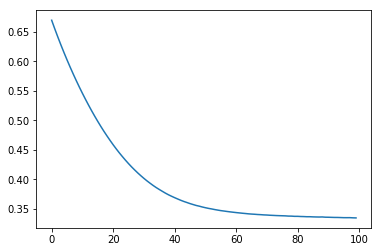

In [43]:
plot_fn(loss_array)

# Testing

In [44]:
pred_y = model(test_x)

In [45]:
pred_y.shape

torch.Size([10297, 2])

In [46]:
res = np.argmax(pred_y.detach().numpy() , axis = 1)
res.shape

(10297,)

In [47]:
from sklearn.metrics import classification_report

In [48]:
print(classification_report(test_y , res , target_names = ['Subscribe_No', 'Subscribe_Yes']))

               precision    recall  f1-score   support

 Subscribe_No       0.88      1.00      0.94      9111
Subscribe_Yes       0.00      0.00      0.00      1186

     accuracy                           0.88     10297
    macro avg       0.44      0.50      0.47     10297
 weighted avg       0.78      0.88      0.83     10297



c:\softwares\anaconda\envs\demo\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
